# Herron Topic 3 - Practice (Monday 2:45 PM, Section 3)

## Announcements

- Team Project 1 grades posted
    - Mean of 81% and median of 84%
    - 100% on Teammates reviews pushes mean to 84%, which is about the target
    - Overall course mean is 86%, so I would curve up overall course grades about 4% if posted grades today, much more at the low end
    - However, I cannot commit to a curve today
- 20,000 XP on DataCamp due by 11:59 PM on Friday

##  Practice

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import seaborn as sns
import statsmodels.formula.api as smf

In [4]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

### Plot the security market line (SML) for a variety of asset classes

Use the past three years of daily data for the following exhange traded funds (ETFs):

1. SPY (SPDR---Standard and Poor's Depository Receipts---ETF for the S&P 500 index)
1. BIL (SPDR ETF for 1-3 month Treasury bills)
1. GLD (SPDR ETF for gold)
1. JNK (SPDR ETF for high-yield debt)
1. MDY (SPDR ETF for S&P 400 mid-cap index)
1. SLY (SPDR ETF for S&P 600 small-cap index)
1. SPBO (SPDR ETF for corporate bonds)
1. SPMB (SPDR ETF for mortgage-backed securities)
1. SPTL (SPDR ETF for long-term Treasury bonds)

In [5]:
etf = (
    yf.download(
        tickers='SPY BIL GLD JNK MDY SLY SPBO SPMB SPTL',
        progress=False
    )
    .assign(Date = lambda x: x.index.tz_localize(None))
    .set_index('Date')
    .rename_axis(columns=['Variable', 'Ticker'])
    ['Adj Close']
    .pct_change()
    .dropna()
)

In [6]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900',
        session=session
    )
    [0]
    .rename_axis(columns='Variable')
    .div(100)
)

In [7]:
def mean(ri, ann=252, mul=100):
    return mul * ann * ri.mean()

In [8]:
def beta(ri, rf=ff['RF'], rm_rf=ff['Mkt-RF']):
    ri_rf = ri.sub(rf).dropna()
    return ri_rf.cov(rm_rf) / rm_rf.loc[ri_rf.index].var()

In [9]:
def date_range(x):
    return f'{x.index[0]:%b %d, %Y} to {x.index[-1]:%b %d, %Y}'

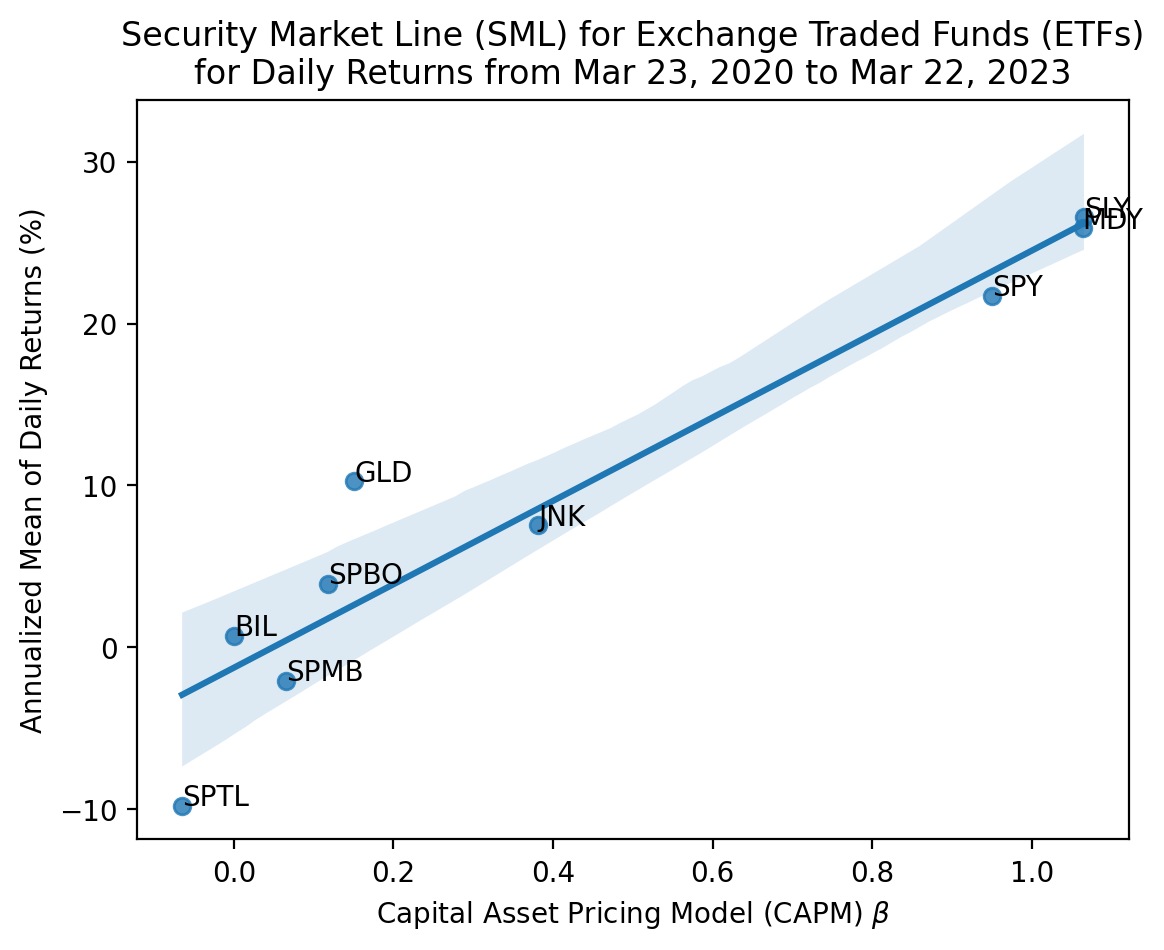

In [10]:
_1 = etf.iloc[-756:]
_2 = _1.agg([mean, beta]).rename_axis(index='Statistic').transpose()

sns.regplot(x='beta', y='mean', data=_2)
for t, (x, y) in _2[['beta', 'mean']].iterrows():
    plt.annotate(text=t, xy=(x, y)) # use a for-loop to add tickers

plt.ylabel('Annualized Mean of Daily Returns (%)')
plt.xlabel(r'Capital Asset Pricing Model (CAPM) $\beta$')
plt.title(
    'Security Market Line (SML) for Exchange Traded Funds (ETFs)\n' +
    'for Daily Returns from ' + _1.pipe(date_range))
plt.show()

***Note the asset-class ETFs fit the SML very well!***

### Plot the SML for the Dow Jones Industrial Average (DJIA) stocks

Use the past three years of daily returns data for the stocks listed on the [DJIA Wikipedia page](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average).
Compare the DJIA SML to the asset class SML above.

We can re-use out code from above!

In [11]:
wiki = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')

In [12]:
djia = (
    yf.download(
        tickers=wiki[1]['Symbol'].to_list(),
        progress=False
    )
    .assign(Date = lambda x: x.index.tz_localize(None))
    .set_index('Date')
    .rename_axis(columns=['Variable', 'Ticker'])
    ['Adj Close']
    .pct_change()
    .dropna()
)

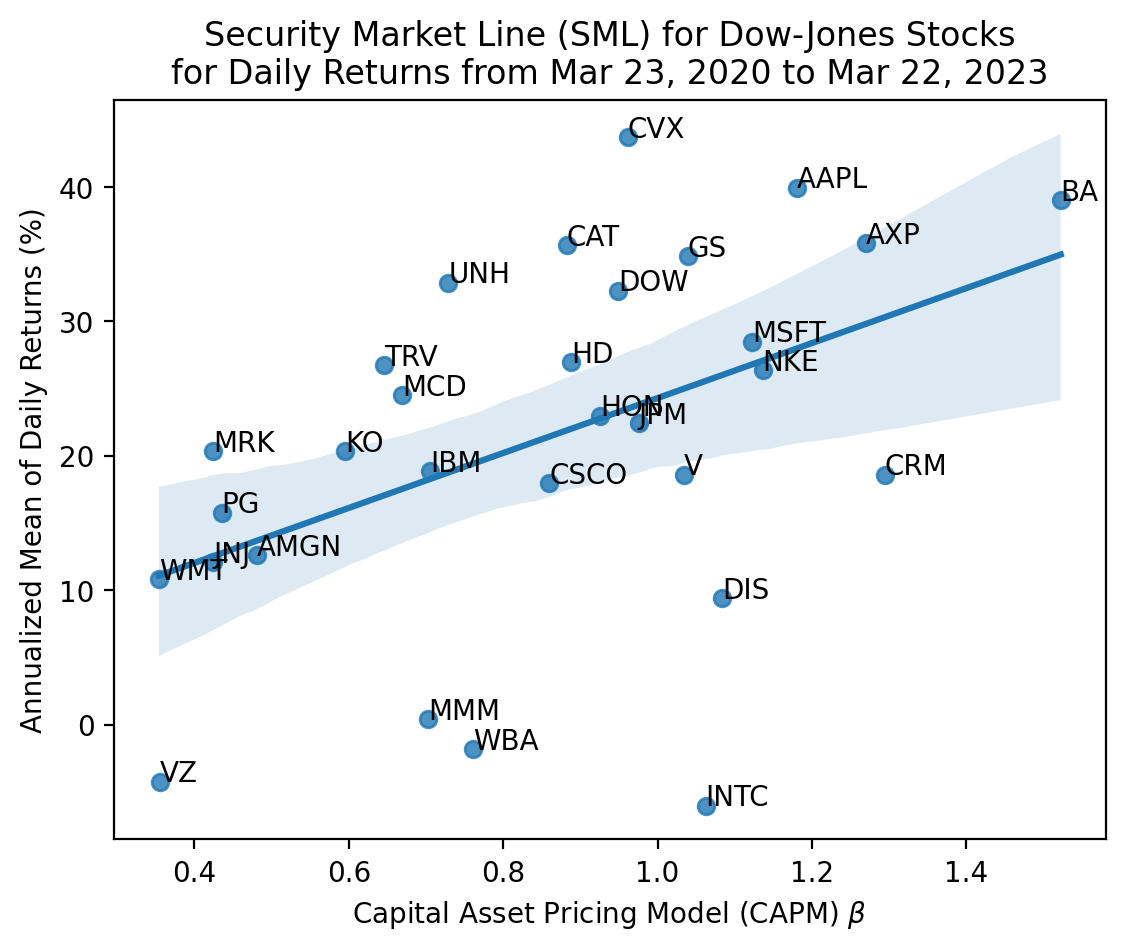

In [13]:
_1 = djia.iloc[-756:]
_2 = _1.agg([mean, beta]).rename_axis(index='Statistic').transpose()

sns.regplot(x='beta', y='mean', data=_2)
for t, (x, y) in _2[['beta', 'mean']].iterrows():
    plt.annotate(text=t, xy=(x, y)) # use a for-loop to add tickers

plt.ylabel('Annualized Mean of Daily Returns (%)')
plt.xlabel(r'Capital Asset Pricing Model (CAPM) $\beta$')
plt.title(
    'Security Market Line (SML) for Dow-Jones Stocks\n' +
    'for Daily Returns from ' + _1.pipe(date_range))
plt.show()

***Note the SML is flatter and the fit is poorer for single stocks (even large ones) relative to ETFs.***

### Plot the SML for the five portfolios formed on beta

Download data for portfolios formed on $\beta$ (`Portfolios_Formed_on_BETA`) from Ken French.
For the value-weighted portfolios, plot realized returns versus $\beta$.
These data should elements `[2]` and `[6]`, respectively.

In [14]:
beta_0 = pdr.DataReader(
    name='Portfolios_Formed_on_BETA',
    data_source='famafrench',
    start='1900',
    session=session
)

print(beta_0['DESCR'])

Portfolios Formed on BETA
-------------------------

This file was created by CMPT_BETA_RETS using the 202301 CRSP database. It contains value- and equal-weighted returns for portfolios formed on BETA. The portfolios are constructed at the end of June. Beta is estimated using monthly returns for the past 60 months (requiring at least 24 months with non-missing returns). Beta is estimated using the Scholes-Williams method. Annual returns are from January to December. Missing data are indicated by -99.99 or -999. The break points include utilities and include financials. The portfolios include utilities and include financials. Copyright 2023 Kenneth R. French

  0 : Value Weighted Returns -- Monthly (715 rows x 15 cols)
  1 : Equal Weighted Returns -- Monthly (715 rows x 15 cols)
  2 : Value Weighted Returns -- Annual from January to December (59 rows x 15 cols)
  3 : Equal Weighted Returns -- Annual from January to December (59 rows x 15 cols)
  4 : Number of Firms in Portfolios (715 ro

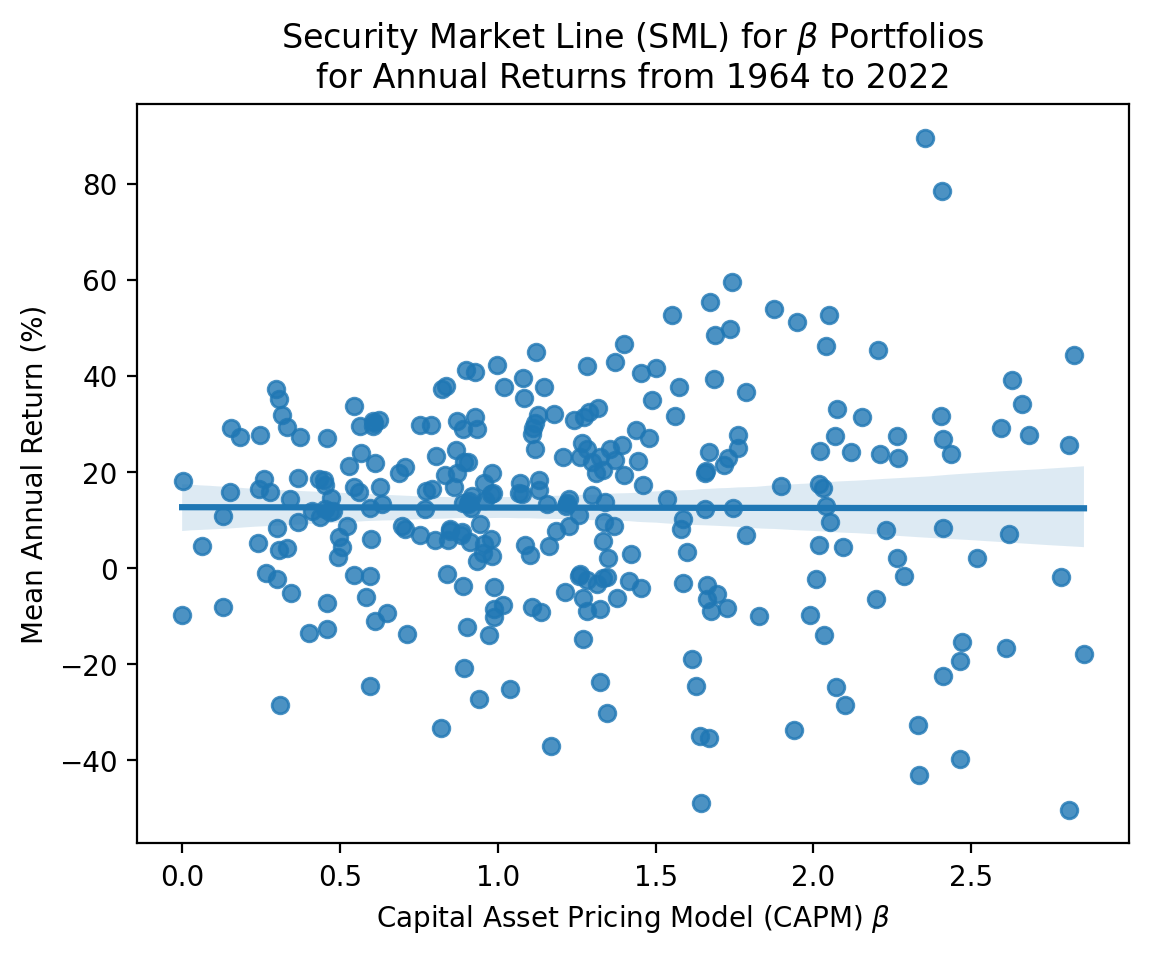

In [15]:
ports = ['Lo 20', 'Qnt 2', 'Qnt 3', 'Qnt 4', 'Hi 20']

_ = (
    pd.concat(
        [
            beta_0[6][ports].shift(), # betas
            beta_0[2][ports] # value-weighted returns
        ],
        axis=1,
        keys=['Beta', 'Return'],
        names=['Statistic', r'$\beta$ Portfolio']
    )
    .stack()
)

sns.regplot(x='Beta', y='Return', data=_)
plt.ylabel('Mean Annual Return (%)')
plt.xlabel(r'Capital Asset Pricing Model (CAPM) $\beta$')
plt.title(
    r'Security Market Line (SML) for $\beta$ Portfolios' +
    f'\nfor Annual Returns from {_.index.get_level_values(0).year[0]} to {_.index.get_level_values(0).year[-1]}'
)
plt.show()

With a wider range of stock $\beta$s, we see the SML is *flat*!
Or at least flatter than we expect.

### Estimate the CAPM $\beta$s on several levered and inverse exchange traded funds (ETFs)

Try the following ETFs:

1. SPY
1. UPRO
1. SPXU

Can you determine what these products do from the data alone?
Estimate $\beta$s and plot cumulative returns.
You may want to pick short periods of time with large market swings.

In [16]:
etf_2 = (
    yf.download(
        tickers='SPY UPRO SPXU',
        progress=False
    )
    .assign(Date = lambda x: x.index.tz_localize(None))
    .set_index('Date')
    .rename_axis(columns=['Variable', 'Ticker'])
    ['Adj Close']
    .pct_change()
    .dropna()
)

In [17]:
etf_2.apply(beta).rename(r'$\beta$')

Ticker
SPXU   -2.8660
SPY     0.9586
UPRO    2.8814
Name: $\beta$, dtype: float64

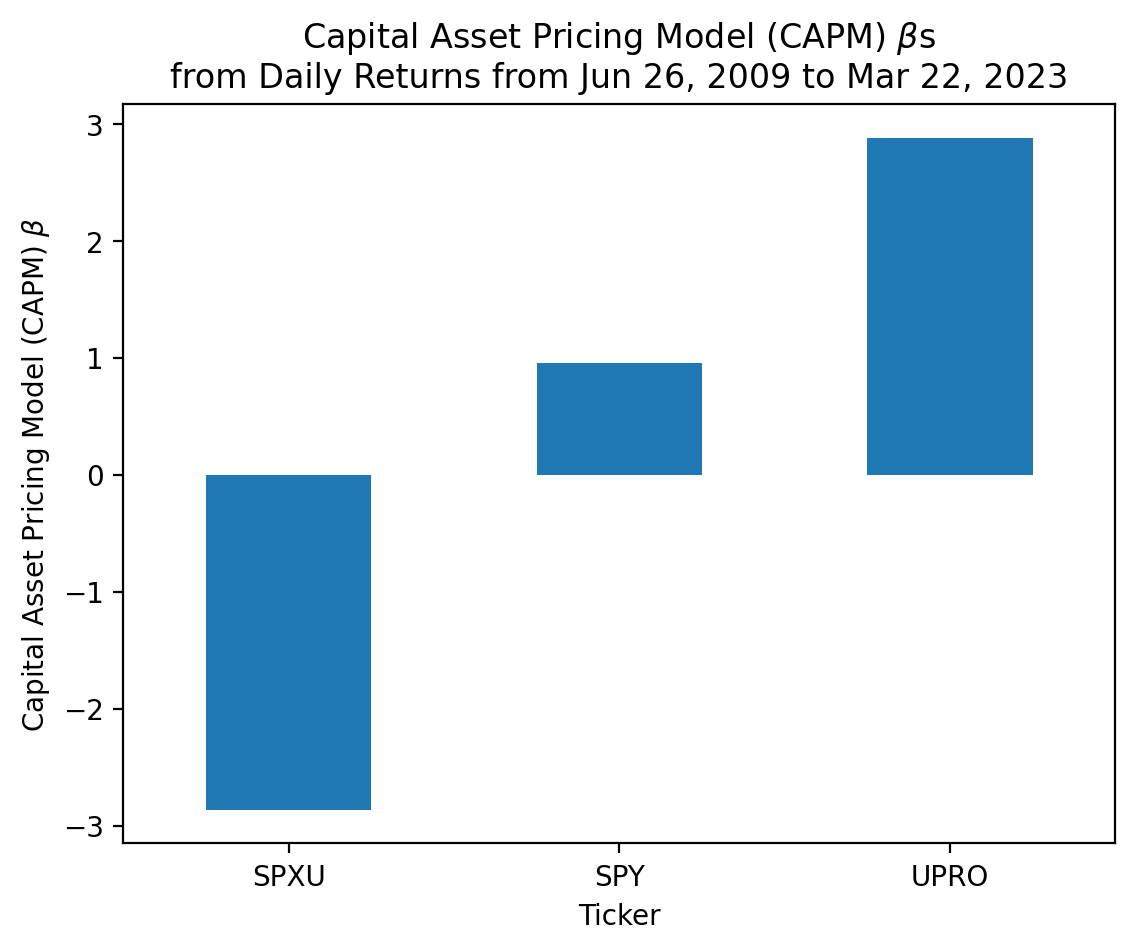

In [18]:
etf_2.apply(beta).plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel(r'Capital Asset Pricing Model (CAPM) $\beta$')
plt.title(
    r'Capital Asset Pricing Model (CAPM) $\beta$s' + 
    f'\nfrom Daily Returns from {etf_2.pipe(date_range)}'
)
plt.show()

UPRO is a tripled-levered S&P 500 ETF,
SPY is an S&P 500 ETF,
and
SPXU is an *inverse* triple-levered S&P 500 ETF.
More on levered and inverse ETFs [here](https://www.schwab.com/learn/story/what-are-leveraged-inverse-etfs-etns-how-do-they-work).

### Explore the size factor

#### Estimate $\alpha$s for the ten portfolios formed on size

Academics started researching size-based portfolios in the early 1980s, so you may want to focus on the pre-1980 sample.

In [19]:
size_0 = pdr.DataReader(
    name='Portfolios_Formed_on_ME',
    data_source='famafrench',
    start='1900',
    session=session
)

print(size_0['DESCR'])

Portfolios Formed on ME
-----------------------

This file was created by CMPT_ME_RETS using the 202301 CRSP database. It contains value- and equal-weighted returns for size portfolios. Each record contains returns for: Negative (not used) 30% 40% 30%   5 Quintiles  10 Deciles The portfolios are constructed at the end of Jun. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French

  0 : Value Weight Returns -- Monthly (1159 rows x 19 cols)
  1 : Equal Weight Returns -- Monthly (1159 rows x 19 cols)
  2 : Value Weight Returns -- Annual from January to December (96 rows x 19 cols)
  3 : Equal Weight Returns -- Annual from January to December (96 rows x 19 cols)
  4 : Number of Firms in Portfolios (1159 rows x 19 cols)
  5 : Average Firm Size (1159 rows x 19 cols)


In [20]:
ff_m = pdr.DataReader(
    name='F-F_Research_Data_Factors',
    data_source='famafrench',
    start='1900',
    session=session
)

***In class, I used `size_0[0]` for value-weighted returns. To exaggerate the $\alpha$ of small stock strategies, I will use equal-weighted returns here.***
Equal-weighted portfolio assign higher weights to small stocks, and lower weights to large stocks.

In [21]:
ports = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']
joined = size_0[1][ports].join(ff_m[0])
joined.head()

,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,
1926-07,-1.4200,0.2900,-0.1500,0.8800,1.4500,1.8500,1.6300,1.3800,3.3800,3.2900,2.9600,-2.5600,-2.4300,0.2200
1926-08,4.6100,2.5900,4.0300,3.2400,2.6600,4.6700,1.5400,1.6300,0.9800,3.7000,2.6400,-1.1700,3.8200,0.2500
1926-09,0.9100,-1.8700,-2.2700,-0.8400,0.1200,-0.0700,-1.5800,0.6400,-0.8600,0.6700,0.3600,-1.4000,0.1300,0.2300
1926-10,-4.7200,-1.7700,-3.3600,-5.0100,-3.0900,-2.7100,-3.4500,-3.2700,-3.4700,-2.4300,-3.2400,-0.0900,0.7000,0.3200
1926-11,-0.7700,-0.3200,-0.2900,4.7900,3.1700,3.5800,3.8000,2.9500,3.6100,2.7000,2.5300,-0.1000,-0.5100,0.3100


In [22]:
models = [smf.ols(f'I(Q("{p}") - RF) ~ Q("Mkt-RF")', data=joined.loc[:'1979']) for p in ports]
fits = [m.fit() for m in models]

coefs = (
    pd.concat(
        objs=[f.params for f in fits],
        axis=1,
        keys=ports
    )
    .rename_axis(index='Coefficient', columns='Size Portfolio')
    .transpose()
)

ses = [f.bse[0] for f in fits]

We can get the standard errors, too.
The standard errors are in the `.params` attribute of our model fits.

In [23]:
ses = [f.bse[0] for f in fits]

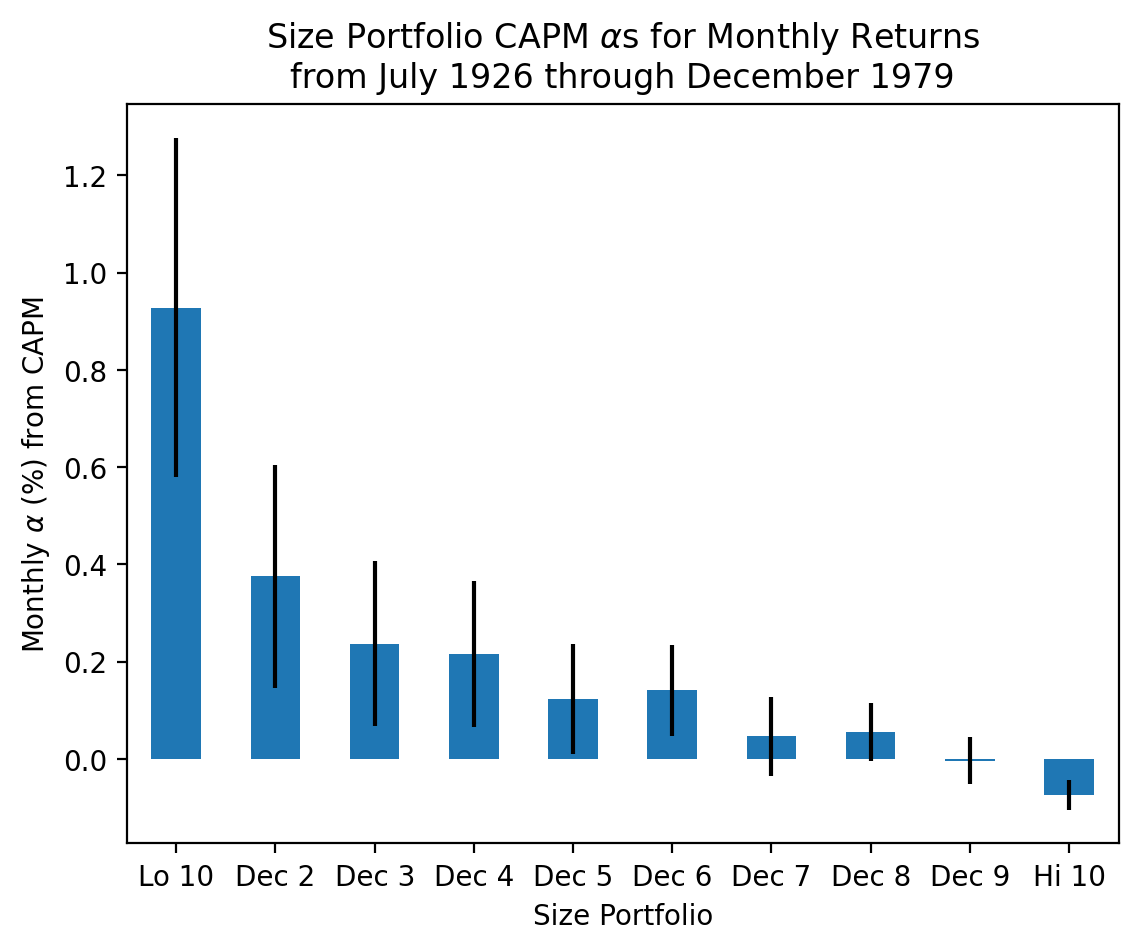

In [24]:
coefs['Intercept'].plot(kind='bar', yerr=ses)
plt.ylabel(r'Monthly $\alpha$ (%) from CAPM')
plt.xticks(rotation=0)
plt.title(
    r'Size Portfolio CAPM $\alpha$s for Monthly Returns' +
    '\nfrom July 1926 through December 1979'
)
plt.show()

The size effect (i.e., the CAPM $\alpha$ for small stock portfolios) appears large!
We will dig a little deeper!

#### Are the returns on these ten portfolios formed on size concentrated in a specific month?

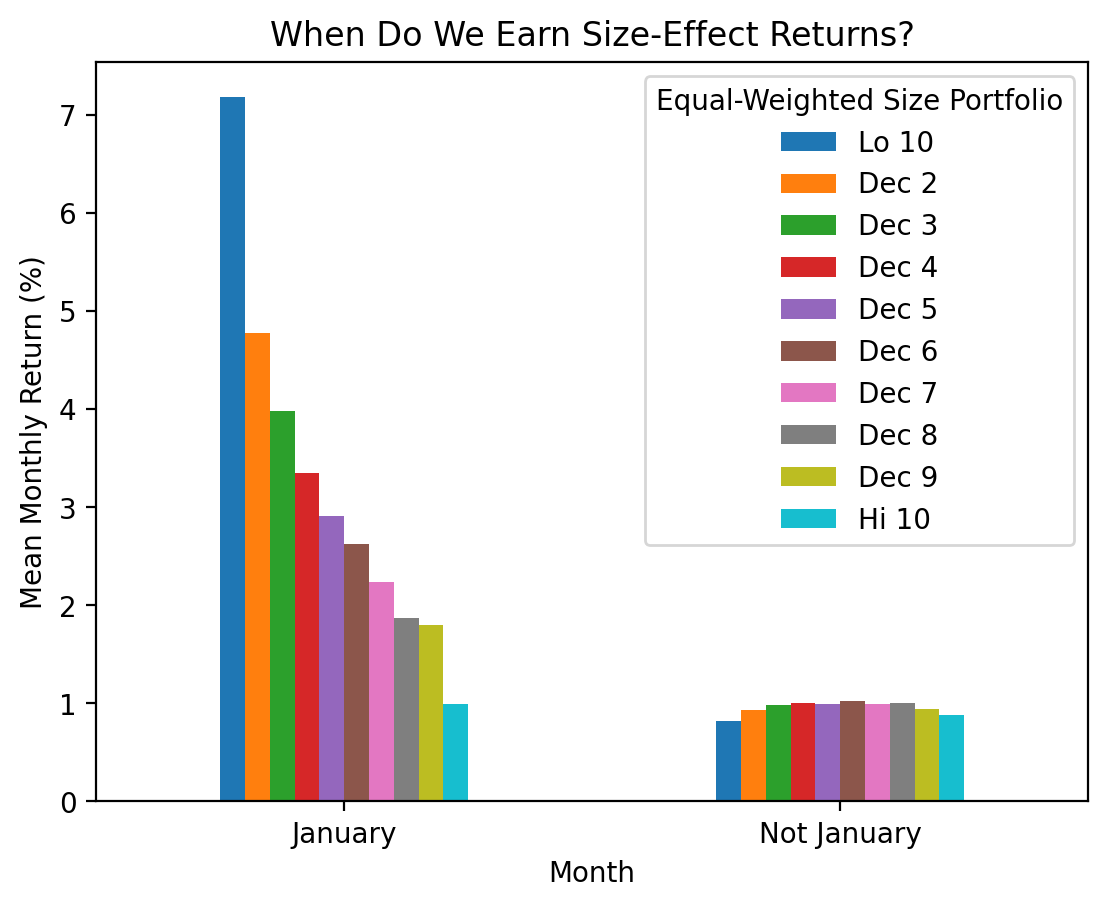

In [25]:
(
    size_0[0][ports]
    .groupby(lambda x: np.where(x.month==1, 'January', 'Not January'))
    .mean()
    .rename_axis(index='Month', columns='Equal-Weighted Size Portfolio')
    .plot(kind='bar')
)

plt.xticks(rotation=0)
plt.ylabel('Mean Monthly Return (%)')
plt.title('When Do We Earn Size-Effect Returns?')
plt.show()

We earn size effect returns in January!
The size effect is likely due to tax-loss harvesting in small stocks.

#### Compare the size factor to the market factor

You may want to consider mean excess returns by decade.

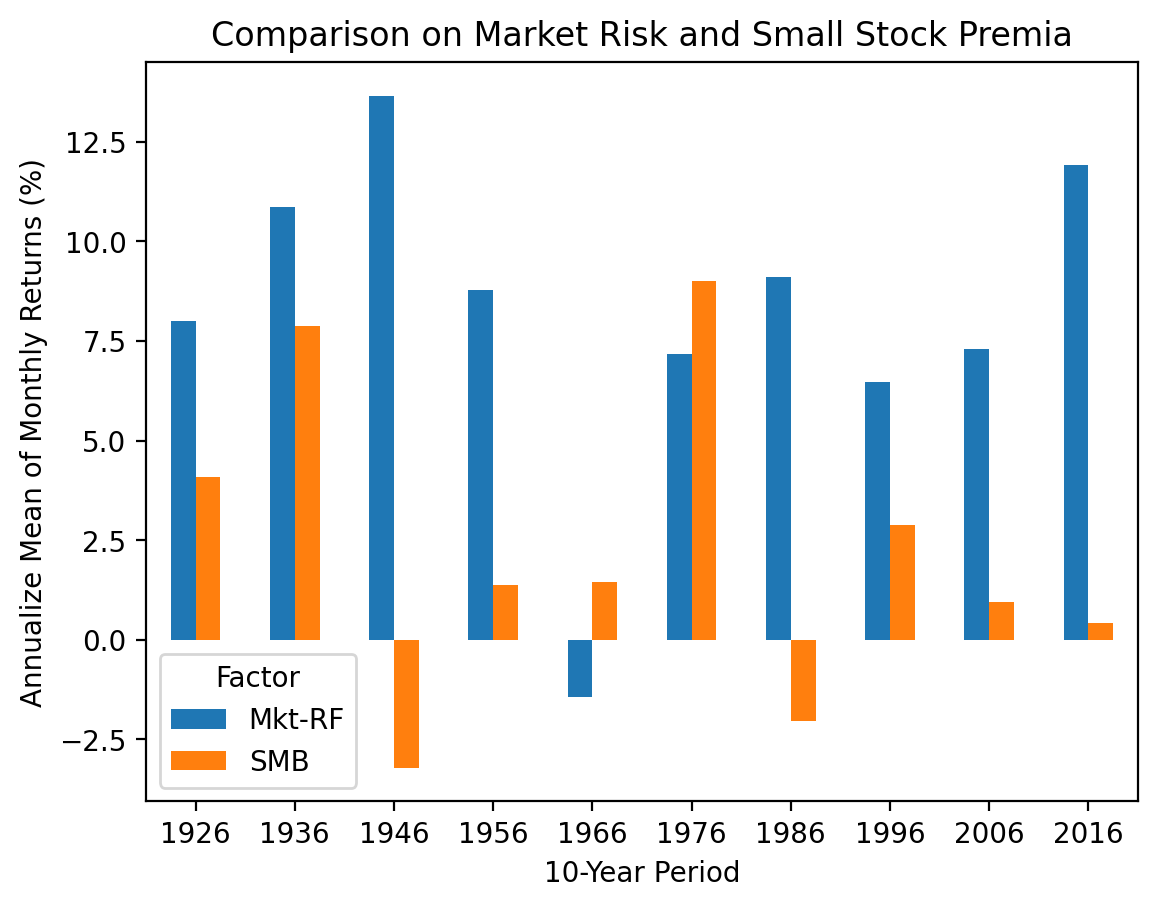

In [26]:
(
    ff_m[0][['Mkt-RF', 'SMB']]
    .resample('10Y')
    .mean()
    .mul(12)
    .rename_axis(index='10-Year Period', columns='Factor')
    .plot(kind='bar')
)

plt.xticks(rotation=0)
plt.ylabel('Annualize Mean of Monthly Returns (%)')
plt.title('Comparison on Market Risk and Small Stock Premia')
plt.show()

The size factor (SMB) may have $\alpha$ early in the sample, but it rarely generates outsize returns.
Plus, the size factor has returned (effectively) zero the last two decades of the sample (2006-2015 and 2016-today).

### Repeat the exercises above with the value factor

In [27]:
hml_0 = pdr.DataReader(
    name='Portfolios_Formed_on_BE-ME',
    data_source='famafrench',
    start='1900',
    session=session
)

print(hml_0['DESCR'])

Portfolios Formed on BE-ME
--------------------------

This file was created by CMPT_BEME_RETS using the 202301 CRSP database. It contains value- and equal-weighted returns for portfolios formed on BE/ME. The portfolios are constructed at the end of June. BE/ME is book equity at the last fiscal year end of the prior calendar year divided by ME at the end of December of the prior year. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. The break points use Compustat firms plus the firms hand-collected from the Moodys Industrial, Utilities, Transportation, and Financial Manuals. The portfolios use Compustat firms plus the firms hand-collected from the Moodys Industrial, Utilities, Transportation, and Financial Manuals. The break points include utilities and include financials. The portfolios include utilities and include financials. Copyright 2023 Kenneth R. French

  0 : Value Weight Returns -- Monthly (1159 rows x 19 cols)
  1 : Equal Weight 

In [28]:
ports = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']
joined = hml_0[1][ports].join(ff_m[0])
joined.head()

,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,
1926-07,4.5200,1.5300,1.9900,2.0700,0.0700,1.9600,0.2300,2.8800,-1.4400,-0.1700,2.9600,-2.5600,-2.4300,0.2200
1926-08,0.3400,0.5100,3.0000,0.8100,2.7900,1.6600,0.9600,4.4900,5.8100,6.4800,2.6400,-1.1700,3.8200,0.2500
1926-09,0.3600,-4.2500,-1.1600,0.8800,-0.7400,-1.1000,-0.5000,-1.4500,-2.1700,3.9300,0.3600,-1.4000,0.1300,0.2300
1926-10,-4.1200,-3.8300,-2.6700,-2.7800,-2.3100,-3.9800,-4.1800,-2.0100,-4.5800,-1.8800,-3.2400,-0.0900,0.7000,0.3200
1926-11,4.4400,0.4700,1.3500,4.4500,3.5600,1.4700,3.5100,3.5100,2.2300,2.6600,2.5300,-0.1000,-0.5100,0.3100


In [29]:
models = [smf.ols(f'I(Q("{p}") - RF) ~ Q("Mkt-RF")', data=joined) for p in ports]

fits = [m.fit() for m in models]

coefs = (
    pd.concat(
        objs=[f.params for f in fits],
        axis=1,
        keys=ports
    )
    .rename_axis(index='Coefficient', columns='Equal-Weighted Value Portfolio')
    .transpose()
)

We can get the standard errors, too.
The standard errors are in the `.params` attribute of our model fits.

In [30]:
ses = [f.bse[0] for f in fits]

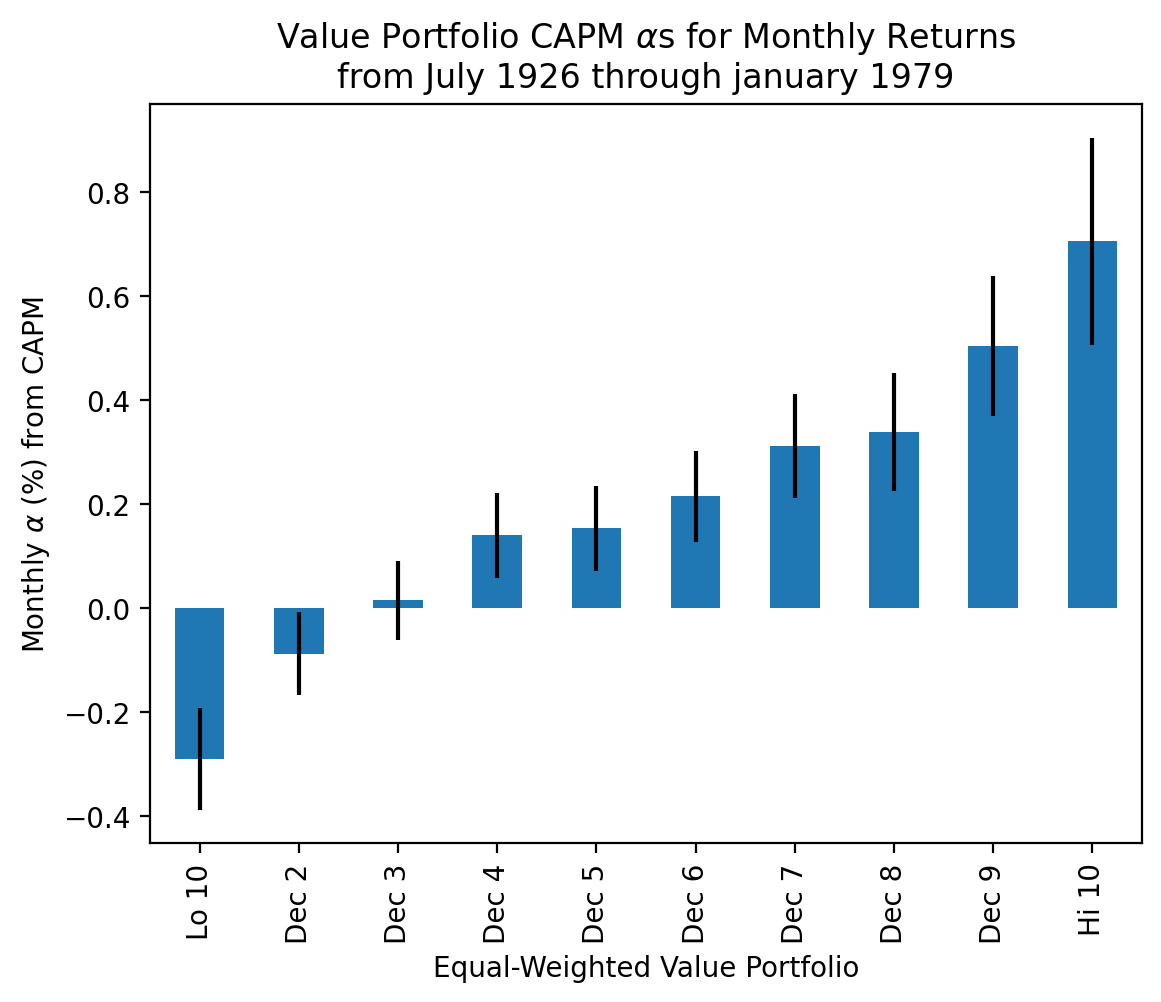

In [31]:
coefs['Intercept'].plot(kind='bar', yerr=ses)
plt.ylabel(r'Monthly $\alpha$ (%) from CAPM')
# plt.xticks(rotation=0)
plt.title(
    r'Value Portfolio CAPM $\alpha$s for Monthly Returns' +
    '\nfrom July 1926 through january 1979'
)
plt.show()

### Repeat the exercises above with the momentum factor

You may find it helpful to consider the worst months and years for the momentum factor.

In [32]:
mom_0 = pdr.DataReader(
    name='10_Portfolios_Prior_12_2',
    data_source='famafrench',
    start='1900',
    session=session
)

print(mom_0['DESCR'])

10 Portfolios Prior 12 2
------------------------

This file was created by CMPT_PRIOR_RETS using the 202301 CRSP database. It contains value- and equal-weighted returns for 10 prior-return portfolios. The portfolios are constructed monthly. PRIOR_RET is from -12 to - 2. The annual returns are from January to December. Missing data are indicated by -99.99 or -999.

  0 : Average Value Weighted Returns -- Monthly (1153 rows x 10 cols)
  1 : Average Equal Weighted Returns -- Monthly (1153 rows x 10 cols)
  2 : Average Value Weighted Returns -- Annual (96 rows x 10 cols)
  3 : Average Equal Weighted Returns -- Annual (96 rows x 10 cols)
  4 : Number of Firms in Portfolios (1153 rows x 10 cols)
  5 : Average Firm Size (1153 rows x 10 cols)
  6 : Value-Weighted Average of Prior Returns (96 rows x 10 cols)


In [33]:
ports = ['Lo PRIOR', 'PRIOR 2', 'PRIOR 3', 'PRIOR 4', 'PRIOR 5', 'PRIOR 6', 'PRIOR 7', 'PRIOR 8', 'PRIOR 9', 'Hi PRIOR']
joined = mom_0[1][ports].join(ff_m[0])
joined.head()

,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,
1927-01,-0.4700,1.0400,4.1700,2.4000,-0.3100,3.0800,1.4800,0.6400,-0.5900,1.1800,-0.0600,-0.3700,4.5400,0.2500
1927-02,8.4900,3.8800,8.3300,7.5900,4.7900,5.4700,5.4000,4.3000,5.7600,5.5800,4.1800,0.0400,2.9400,0.2600
1927-03,-6.1500,-5.1100,-2.3800,-1.6000,-1.6300,-1.7000,0.4900,-1.5300,0.3700,-0.7800,0.1300,-1.6500,-2.6100,0.3000
1927-04,2.6100,-0.9300,0.1000,-1.2000,0.0900,0.4000,1.2700,-0.5700,2.2200,4.4200,0.4600,0.3000,0.8100,0.2500
1927-05,1.1200,3.7300,6.0100,5.1700,7.5500,9.2700,6.6100,8.2100,6.9100,10.0000,5.4400,1.5300,4.7300,0.3000


In [34]:
models = [smf.ols(f'I(Q("{p}") - RF) ~ Q("Mkt-RF")', data=joined) for p in ports]

In [35]:
fits = [m.fit() for m in models]

In [36]:
coefs = (
    pd.concat(
        objs=[f.params for f in fits],
        axis=1,
        keys=ports
    )
    .rename_axis(index='Coefficient', columns='Equal-Weighted Momentum Portfolio')
    .transpose()
)

We can get the standard errors, too.
The standard errors are in the `.params` attribute of our model fits.

In [37]:
ses = [f.bse[0] for f in fits]

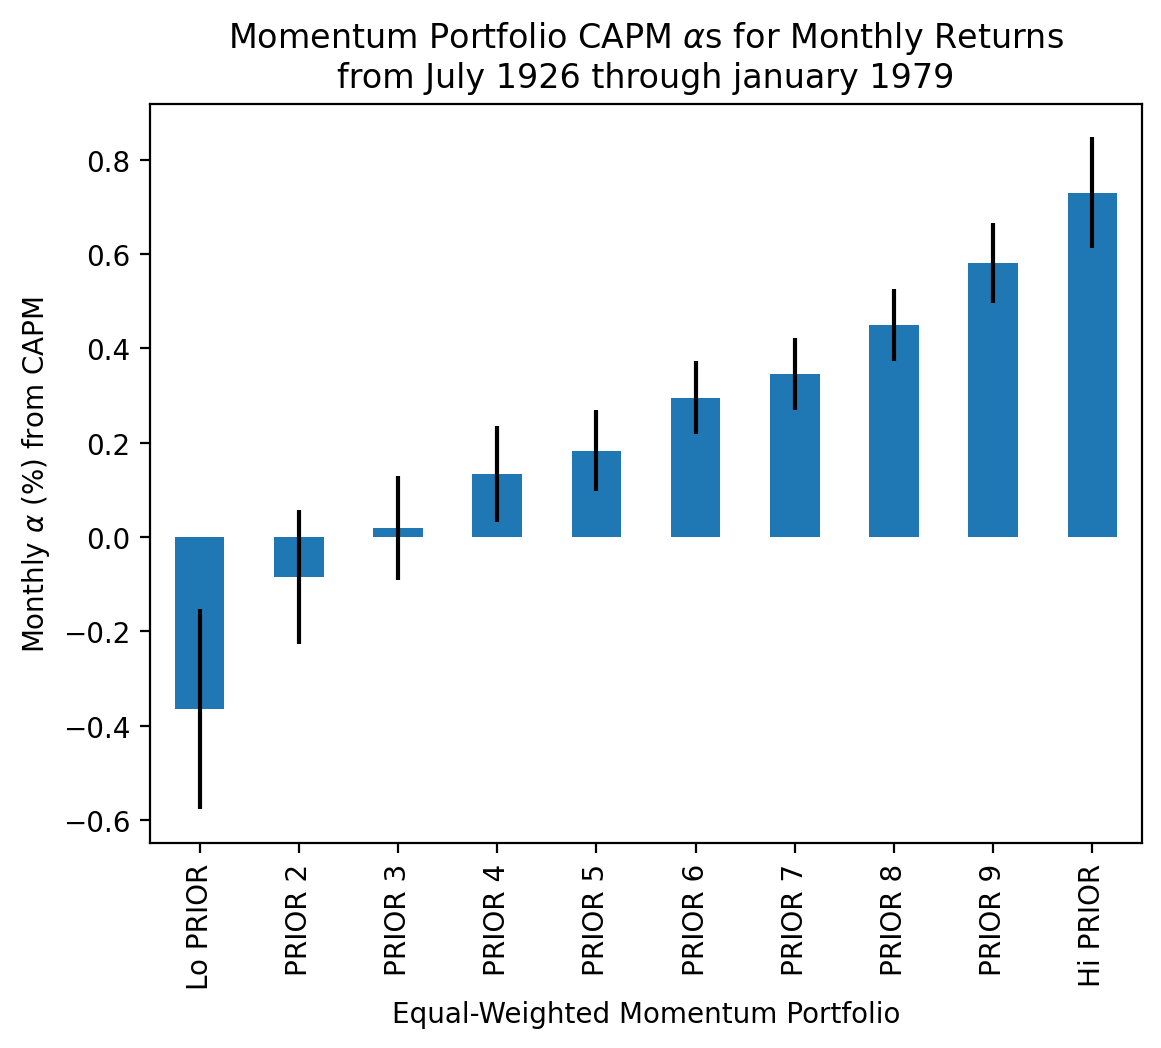

In [38]:
coefs['Intercept'].plot(kind='bar', yerr=ses)
plt.ylabel(r'Monthly $\alpha$ (%) from CAPM')
# plt.xticks(rotation=0)
plt.title(
    r'Momentum Portfolio CAPM $\alpha$s for Monthly Returns' +
    '\nfrom July 1926 through january 1979'
)
plt.show()

### Plot the coefficient estimates from a rolling Fama-French three-factor model for Berkshire Hathaway

Use a three-year window with daily returns.
How has Buffett's $\alpha$ and $\beta$s changed over the past four decades?

In [39]:
brk = (
    yf.download(tickers='BRK-A', progress=False)
    .assign(Date = lambda x: x.index.tz_localize(None))
    .set_index('Date')
    .rename_axis(columns=['Variable'])
    .assign(R=lambda x: x['Adj Close'].pct_change().mul(100))
    .dropna()
    .join(
        pdr.DataReader(
            name='F-F_Research_Data_Factors_daily',
            data_source='famafrench',
            start='1900',
            session=session
        )[0],
        how='inner'
    )
)

In [40]:
from statsmodels.regression.rolling import RollingOLS

In [41]:
coefs = (
    RollingOLS.from_formula(
        formula='I(R-RF) ~ Q("Mkt-RF") + SMB + HML',
        data=brk,
        window=3*252
    )
    .fit()
    .params
    .rename_axis(columns='Coefficient')
    .rename(columns={'Q("Mkt-RF")': 'Mkt-RF'})
)

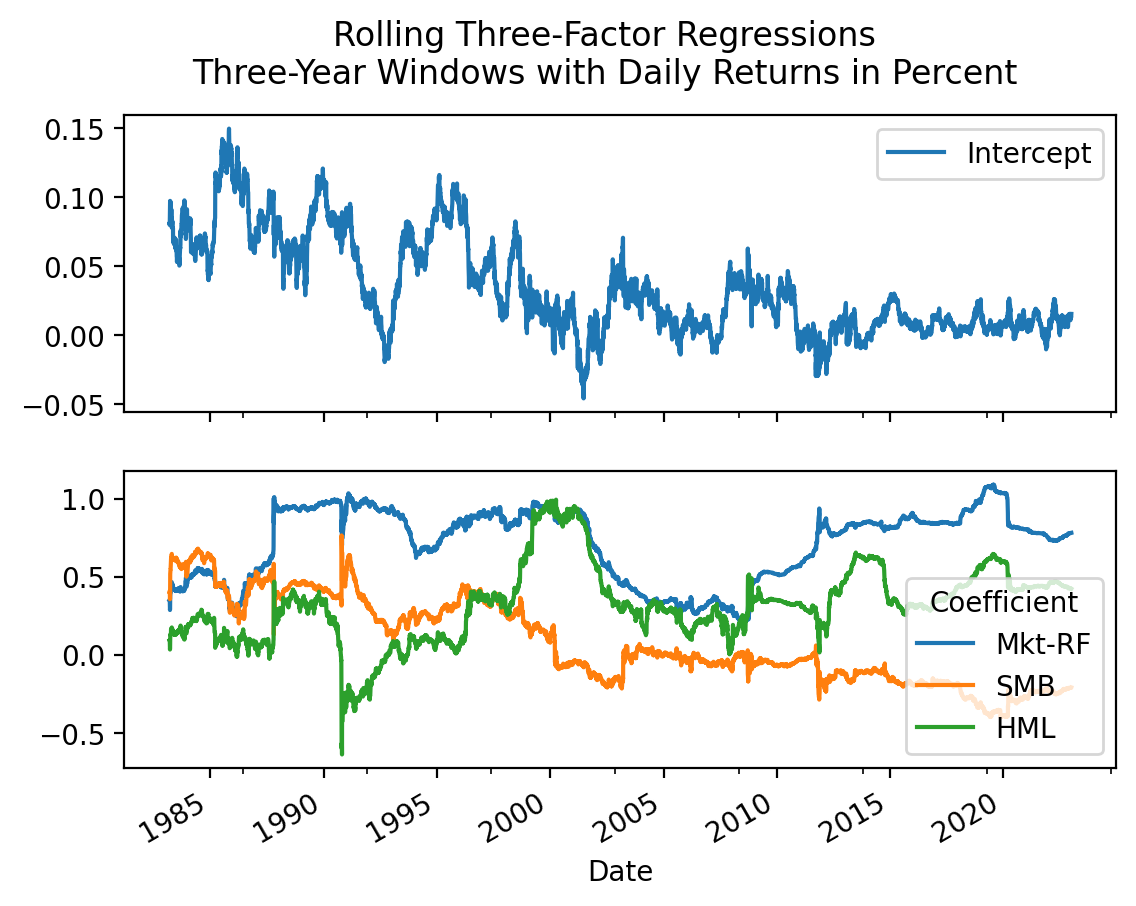

In [42]:
fig, ax = plt.subplots(2, 1, sharex=True)
coefs['Intercept'].plot(ax=ax[0], legend=True)
coefs.drop('Intercept', axis=1).plot(ax=ax[1])
plt.suptitle(
    'Rolling Three-Factor Regressions' +
    '\nThree-Year Windows with Daily Returns in Percent'
)
plt.show()

Buffett's $\alpha$ was large, but has declined to zero.
Also, his loading on SMB (size factor) has gone from positive to negative, indicating that he has moved from small stocks to large stocks as Berkshire Hathaway has grown.

### Use the three-, four-, and five-factor models to determine how the ARKK Innovation ETF generates returns 